## Hodgkin-Huxley model with one channel in response to several voltage-clamps protocols
### Channel identity. ICG id: 1707, ModelDB id: 2488

In [4]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt

## Voltage-clamp protocol

In [6]:
prot = ['v_act','v_inact','v_deact','v_ap','v_ramp']
p = 0
protocols = pd.read_csv('./protocols/k_channels/'+prot[p]+'.dat',sep='\t')
protocols = protocols.drop(protocols.columns[-1],axis=1)

# extract voltages and time
protocols1 = protocols.values

V = protocols1[:,1:].T
t = protocols1[:,0]
tstep = t[2]-t[1] # ms
t[0] = t[1]-tstep # corrected change in time step

## Parameters and kinetics

In [7]:
# parameters
celsius = 37    # original temperature
temp = 23       # reference temperature
q10 = 2.3       # temperature sensitivity
tadj = q10**((celsius - temp)/10)

# length and diameter equal to 20 um
A_soma = np.pi*((20.*1e-4)**2)  # cm2

C = 1 # uF/cm2

g_L = 3.334e-2 # mS/cm2
E_L = -80 # not sure which one is used in Podlaski et al. 2017, mV

gbar_K = 1.0 # mS/cm2
E_K = -86.7 # mV

###############################################################################
# kinetics
def efun(z):
    ind = np.abs(z) < 1e-4
    efun1 = z*1.
    efun1[ind] = 1 - z[ind]/2
    efun1[~ind] = z[~ind] / (np.exp(z[~ind]) - 1)
    return efun1

def alpha_n(x):
    v1 = x - 25
    return 0.02 * 9 * efun(-v1/9)
    
def beta_n(x):
    v1 = x - 25
    return 0.002 * 9 * efun(v1/9)

## Simulation

In [8]:
volt_clamp = 1 # if voltage-clamp, volt_clamp=1

t_sim = time.time()

if volt_clamp ==1:
    n = np.zeros_like(V)    
    n[:,0] = alpha_n(V[:,0])/(alpha_n(V[:,0])+beta_n(V[:,0]))

    for i in range(1, t.shape[0]):
        n[:,i] = n[:,i-1] + tstep*(alpha_n(V[:,i-1])*(1-n[:,i-1]) - beta_n(V[:,i-1])*n[:,i-1])*tadj
    
else:    
    V = np.zeros_like(t)+E_L # baseline voltage
    n = np.zeros_like(t)

    n[0] = alpha_n(V[0])/(alpha_n(V[0])+beta_n(V[0]))
    
    for i in range(1, t.shape[0]):

        # currents
        I_K = tadj*n[i-1]*gbar_K*(V[i-1]-E_K)
        I_L = tadj*g_L*(V[i-1]-E_L)
        I_ion = I[i-1] - I_K - I_L

        ###############################
        V[i] = V[i-1] + tstep*I_ion/C
        n[i] = n[i-1] + tstep*(alpha_n(V[i-1])*(1-n[i-1]) - beta_n(V[i-1])*n[i-1])*tadj


print(time.time() - t_sim)

I_K = tadj*n*gbar_K*(V-E_K)
I_K = I_K/np.max(I_K)
# I_L = tadj*g_L*(V-E_L)
# I_tot = (I_K + I_L)/np.max(I_K + I_L)

2.7282931804656982


## Plot

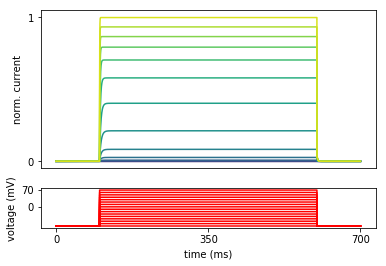

In [9]:
num_levels = len(V[:,0])
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_levels) for i in range(num_levels)]

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_levels):
    plt.plot(t,I_K[i,], color = col1[i])
plt.ylabel('norm. current')
ax.set_xticks([])
ax.set_yticks([0, 1.001*np.max(I_K)])

ax = plt.subplot(gs[1])
for i in range(num_levels):
    plt.plot(t, V[i,],'r')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

duration = np.max(t)
ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, np.max(V)])

plt.show()

## Checking model implementation against it

In [10]:
from lfimodels.channelomics.Channel import Channel
m = Channel()

import numpy as np
out = m.gen(np.array([[9, 25, 0.02, 0.002]]))

import matplotlib.pyplot as plt
%matplotlib inline

K2 = out[0][0]['v_act']['data']
t2 = out[0][0]['v_act']['time']

Widget Javascript not detected.  It may not be installed or enabled properly.


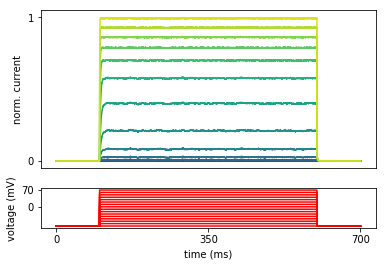

In [11]:
num_levels = len(V[:,0])
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_levels) for i in range(num_levels)]

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_levels):
    plt.plot(t2, K2[i,], color = col1[i])
plt.ylabel('norm. current')
ax.set_xticks([])
ax.set_yticks([0, 1.001*np.max(I_K)])

ax = plt.subplot(gs[1])
for i in range(num_levels):
    plt.plot(t2, V[i,],'r')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

duration = np.max(t)
ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, np.max(V)])

plt.show()